In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
import gensim.corpora as corpora
import pyLDAvis

#Tokenizing:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud

#Stemming:
from nltk.stem import SnowballStemmer

# Removing stopwords:
from nltk.corpus import stopwords
import os

warnings.filterwarnings("ignore")
df = pd.read_excel('/Users/Charlotte/Desktop/A2_Data.xlsx')

[nltk_data] Downloading package punkt to /Users/Charlotte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Text preparation

In [2]:
df.isnull().sum().sort_values(ascending=False)
#The ratio of missing value
print('The Ratio of Missing Value: %.4f' %(df['Summary'].isnull().sum()/len(df))) 
#There are many missing value in 'Summary' , the ratio of missing value in 'Summary' is about 85.37% of all. 


The Ratio of Missing Value: 0.8537


In [3]:
df=df.drop(['Summary'], axis=1)
df.drop(columns='ID',inplace=True)
df.drop(columns='User',inplace=True)
#it 's hard to predict the missing with 15% of existing value, plus the missing value are text format. Thus i decided to drop this column and other meaningless columns.



In [4]:
def process_review_length(df):
    
    df['Review_Split'] = df['Review'].str.split(" ")
    
    df['Review_Length'] = df['Review_Split'].str.len()
    
    del df['Review_Split']
    
    return df

In [5]:
process_review_length(df)

,Date,Review,Rating,Version,AppStore,Review_Length
0,2020-04-27,So try to help. My mobile phone number nor my ...,1,1,Apple,36
1,2020-04-27,I am unable to pass the point of registering m...,1,1,Apple,35
2,2020-04-27,Tried several times. Does not recognise my pho...,1,1,Apple,23
3,2020-04-27,This is poorâ€” it wonâ€™t allow me to put in ...,1,1,Apple,14
4,2020-04-27,Tried 30+ times over two days to try and regis...,2,1,Apple,67
...,...,...,...,...,...,...
10332,2021-01-09,I don't know if it really did anything at all....,2,2,Google,21
10333,2021-01-09,Extreme battery use since the Dec update. Sorr...,1,2,Google,12
10334,2021-01-09,Battery is getting killed. Only noticed recent...,1,2,Google,27
10335,2021-01-09,"Like others, trying to do the right thing but ...",1,2,Google,17


In [6]:
def prepare_review (df):
    #Tokenize:
    df['Review_preparing']=df['Review'].apply(word_tokenize)
    
    #Lower case:
    df['Review_preparing']=df['Review_preparing'].apply(lambda x: [word.lower() for word in x])
    
    #Stemming:
    My_SnowballStemmer = SnowballStemmer('english')
    df['Review_preparing']=df['Review_preparing'].apply(lambda x: [My_SnowballStemmer.stem(word) for word in x ])
    
    # Remove unreadable text:
    df['Review_preparing'] = df['Review_preparing'].apply(lambda x: [re.sub(u"([^\u0030-\u0039\u0041-\u005a\u0061-\u007a])","", sent) for sent in x])
    # Reference: https://blog.csdn.net/weixin_40683253/article/details/89637064
    
    # Removing stopwords: I have extended few stopwords, based on worldcloud.
    My_Stopwords = stopwords.words('English')
    My_Stopwords.extend(['app','tri','wife','hope','seem','issu','wont','think','much','kept','dec','phone','anyth','number','soon','kill','batteri','mobil','sorri','doe','aussi','covid19','name','one','track','back','go','regist','time','updat','recent','uninstal','iphon','enter','download','million','verifi','mani','actual','morn','news','excel'])
    df['Review_preparing']=df['Review_preparing'].apply(lambda x: [word for word in x if word not in My_Stopwords])
    
    #create Review_cleaned as new feature
    df['Review_cleaned'] = df['Review_preparing'].apply(lambda x:" ".join(x))
    
    
    del df['Review_preparing']
    del df['Review']
    
    return df

In [7]:
prepare_review (df)

,Date,Rating,Version,AppStore,Review_Length,Review_cleaned
0,2020-04-27,1,1,Apple,36,help could 2 using
1,2020-04-27,1,1,Apple,35,unabl pass point fix 11 read
2,2020-04-27,1,1,Apple,23,sever recognis iv left lead zero look like
3,2020-04-27,1,1,Apple,14,poor allow put
4,2020-04-27,2,1,Apple,67,30 two day tell problem dual sim last res...
...,...,...,...,...,...,...
10332,2021-01-09,2,2,Google,21,nt know realli qr sign better idea
10333,2021-01-09,1,2,Google,12,extrem use sinc
10334,2021-01-09,1,2,Google,27,get onli notic assum check next lock mayb
10335,2021-01-09,1,2,Google,17,like right thing


In [8]:
def process_datetime(df):
    
    issue_date = np.datetime64('2020-04-26')
    df_date = df['Date']
    df['Review_year']=df_date.dt.year
    
    df['Review_month']=df_date.dt.month
    
    df['days_since_issued']=df['Date']-issue_date
    df['days_since_issued']=df['days_since_issued'].dt.days
    
    del df['Date']
    
    return df

#Extract features from 'date' by first defined the initial date(please see reference) and create a time series, extracted years and months as features.



In [9]:
process_datetime(df)

,Rating,Version,AppStore,Review_Length,Review_cleaned,Review_year,Review_month,days_since_issued
0,1,1,Apple,36,help could 2 using,2020,4,1
1,1,1,Apple,35,unabl pass point fix 11 read,2020,4,1
2,1,1,Apple,23,sever recognis iv left lead zero look like,2020,4,1
3,1,1,Apple,14,poor allow put,2020,4,1
4,2,1,Apple,67,30 two day tell problem dual sim last res...,2020,4,1
...,...,...,...,...,...,...,...,...
10332,2,2,Google,21,nt know realli qr sign better idea,2021,1,258
10333,1,2,Google,12,extrem use sinc,2021,1,258
10334,1,2,Google,27,get onli notic assum check next lock mayb,2021,1,258
10335,1,2,Google,17,like right thing,2021,1,258


# Exploratory analysis: Wordcloud, LDA model & topic modeling

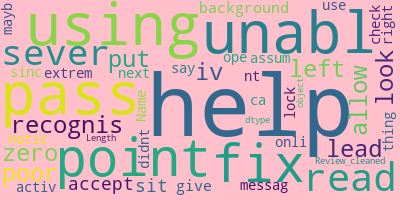

In [10]:
#wordcloud for rating<2
Rating_lower_than_2 = df[df["Rating"]<2]["Review_cleaned"]

My_WordCloud = WordCloud(background_color="pink", max_words=50, contour_width=5, contour_color='black')
My_WordCloud.generate(str(Rating_lower_than_2))
My_WordCloud.to_image()


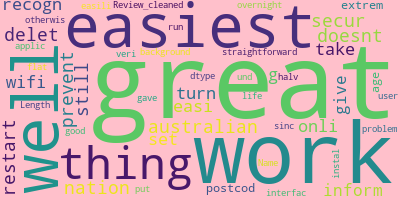

In [11]:
#wordcloud for rating>=3
Rating_higher_equal_than_3 = df[df["Rating"]>=3]["Review_cleaned"]

My_WordCloud = WordCloud(background_color="pink", max_words=50, contour_width=5, contour_color='black')
My_WordCloud.generate(str(Rating_higher_equal_than_3))
My_WordCloud.to_image()

#I generated 2 worldcloud base on rating to discover more meaningless words in Review, i have extended more stopwords base on worldcloud. After remove stopwords, most frequent words in rating_higher_than_3 are mostly positive.  



In [12]:
#pip install gensim==3.4.0

In [13]:
import gensim.corpora as corpora

# Create Dictionary
My_id2word = corpora.Dictionary([df["Review_cleaned"]])

# Term Document Frequency
My_Corpus = [My_id2word.doc2bow([text]) for text in df["Review_cleaned"]]

# Build LDA model
from gensim import models
num_topics=5    #圓圈是topic
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=num_topics)

In [14]:
#conda install -c conda-forge pyldavis

In [15]:
#Visualize the topics

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import os
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

gensimvis.prepare(My_LDA, My_Corpus, My_id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.127317 -0.025071       1        1  20.221357
2     -0.041706 -0.070648       2        1  20.117308
3     -0.003201  0.116599       3        1  19.998803
1     -0.048310  0.006557       4        1  19.973906
4     -0.034100 -0.027438       5        1  19.688625, topic_info=              Term       Freq      Total Category  logprob  loglift
3166          good  47.000000  47.000000  Default  30.0000  30.0000
0                   31.000000  31.000000  Default  29.0000  29.0000
3398         great  19.000000  19.000000  Default  28.0000  28.0000
8824  wo nt accept   9.000000   9.000000  Default  27.0000  27.0000
8285       useless  10.000000  10.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
8374     veri easi   1.638484   2.611693   Topic5  -7.1246   1.1589
2159   easi instal   3.711002   9.959504   Topic5  -6.3071   0.6379
2083          easi   1.238540  18.345545   Topic5  -7.4044  -1.0703
2628        except   1.142371   4.175571   Topic5  -7.4853   0.3290
6271       problem   1.136778   4.172781   Topic5  -7.4902   0.3247

[241 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
0         1  0.926551                                                   
0         3  0.031950                                                   
1         3  0.639236                                                   
23        4  0.766134                                             accept
61        5  0.957070                                              easi 
...     ...       ...                                                ...
9212      5  0.638044  work stuck verif  certain correct yet still co...
9225      5  0.957075                                          work well
9298      2  0.635539                                       would accept
9311      3  0.639244        would given 5 star happi compat appl watch 
9435      1  0.638649                                                yet

[243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

# Sentimnet Analysis & TFIDF

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
My_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df["Review_cleaned"]:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)
    
df['Sentiment']=sentimental_text_list

In [18]:
df.head(10)

,Rating,Version,AppStore,Review_Length,Review_cleaned,Review_year,Review_month,days_since_issued,Sentiment
0,1,1,Apple,36,help could 2 using,2020,4,1,0.4019
1,1,1,Apple,35,unabl pass point fix 11 read,2020,4,1,0.0000
2,1,1,Apple,23,sever recognis iv left lead zero look like,2020,4,1,0.3612
3,1,1,Apple,14,poor allow put,2020,4,1,-0.2960
4,2,1,Apple,67,30 two day tell problem dual sim last res...,2020,4,1,-0.4019
5,1,1,Apple,8,accept,2020,4,1,0.3818
6,5,1,Apple,15,great work well get work,2020,4,1,0.7351
7,1,1,Apple,27,keep say error correct delet reinstal numer ...,2020,4,1,-0.4019
8,5,1,Apple,26,easiest thing australian secur nation prevent ...,2020,4,1,0.2960
9,1,1,Apple,6,accept,2020,4,1,0.3818


In [19]:
#pip install -U scikit-learn scipy matplotlib

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
#參數在這:https://blog.csdn.net/laobai1015/article/details/80451371
My_vectorizer = TfidfVectorizer ()
TFIDF=My_vectorizer.fit_transform(df["Review_cleaned"])

from sklearn.decomposition import TruncatedSVD
My_SVD = TruncatedSVD(n_components=3, n_iter=100)
SVD_Review= My_SVD.fit_transform(TFIDF)

In [21]:
df[['SVD1','SVD2', 'SVD3']]=SVD_Review

In [22]:
df.head(10)

,Rating,Version,AppStore,Review_Length,Review_cleaned,Review_year,Review_month,days_since_issued,Sentiment,SVD1,SVD2,SVD3
0,1,1,Apple,36,help could 2 using,2020,4,1,0.4019,0.048570,0.007709,-0.001385
1,1,1,Apple,35,unabl pass point fix 11 read,2020,4,1,0.0000,0.048813,-0.015531,-0.002857
2,1,1,Apple,23,sever recognis iv left lead zero look like,2020,4,1,0.3612,0.056905,-0.016172,-0.001952
3,1,1,Apple,14,poor allow put,2020,4,1,-0.2960,0.040576,-0.016172,-0.001644
4,2,1,Apple,67,30 two day tell problem dual sim last res...,2020,4,1,-0.4019,0.077479,-0.013544,-0.003745
5,1,1,Apple,8,accept,2020,4,1,0.3818,0.140127,-0.150899,-0.018396
6,5,1,Apple,15,great work well get work,2020,4,1,0.7351,0.340773,0.035221,0.032015
7,1,1,Apple,27,keep say error correct delet reinstal numer ...,2020,4,1,-0.4019,0.132059,-0.080022,-0.012154
8,5,1,Apple,26,easiest thing australian secur nation prevent ...,2020,4,1,0.2960,0.047232,0.010840,0.000378
9,1,1,Apple,6,accept,2020,4,1,0.3818,0.140127,-0.150899,-0.018396


# Investigating the relationships between the extracted features & target variable

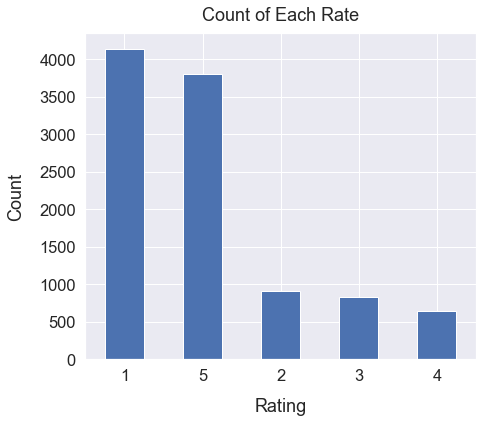

In [23]:
sns.set(font_scale=1.5)
df['Rating'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Rating", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of Each Rate", y=1.02);

#Rating1 accounts for the largest number of totals, followed by rating5, which reflects that users’ review are more bipolar. Ratings 2, 3, and 4 are relatively less, which is reflected on accuracy.

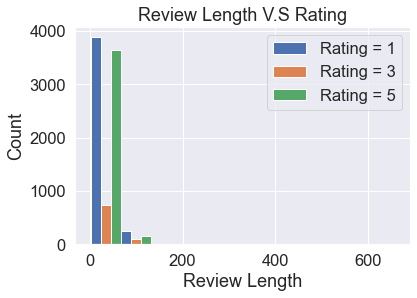

In [24]:
sns.set(font_scale=1.5)
len_0 = df[df['Rating']==1]['Review_Length']
len_1 = df[df['Rating']==3]['Review_Length']
len_2 = df[df['Rating']==5]['Review_Length']

plt.hist([len_0,len_1,len_2],label=['Rating = 1','Rating = 3','Rating = 5'],rwidth=1)
plt.xlabel("Review Length")
plt.ylabel("Count")
plt.title("Review Length V.S Rating")
plt.legend()
plt.show()

#According to the graph, length of review does not reflect on the rating, most of the word count is less than 100 words.

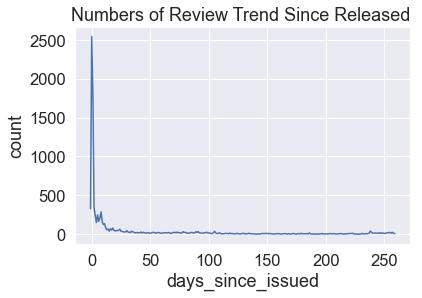

In [25]:
sns.set(font_scale=1.5)
df.groupby('days_since_issued')["Rating"].count().plot(kind="line")
plt.xticks(rotation=360)
plt.ylabel("count")
plt.title("Numbers of Review Trend Since Released ")
plt.show()

#Numbers of review is concentrated in about 20 days after the app is released,few people leave review after 20 days.

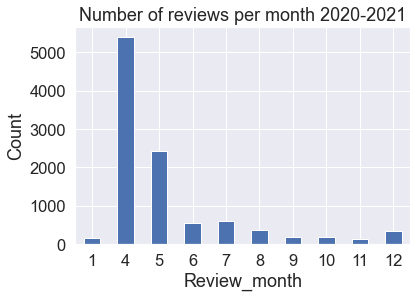

In [26]:
sns.set(font_scale=1.5)
df.groupby('Review_month')["Rating"].count().plot(kind="bar")

#plt.figure(figsize=(8,6), dpi=80)
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Number of reviews per month 2020-2021")
plt.show()

#Numbers of review is concentrated in April and May after the app released.

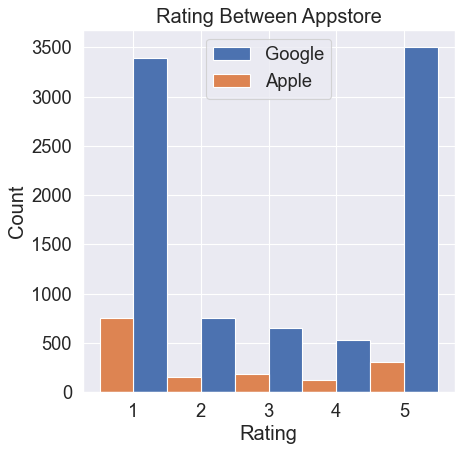

In [27]:
sns.set(font_scale=1.5)
App_apple  = df[df['AppStore']=='Apple'] ['Rating'].value_counts() 
App_google = df[df['AppStore']=='Google']['Rating'].value_counts() 

plt.figure(figsize=(6,6), dpi=80)
plt.bar(App_google.index, App_google.values, width=0.5 ,bottom=None, align='edge', label='Google')
plt.bar(App_apple.index,  App_apple.values, width=-0.5, bottom=None, align='edge', label='Apple')
    
    
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Between Appstore")
plt.legend()
plt.show()

#According to the graph, most of reviews are from Google.

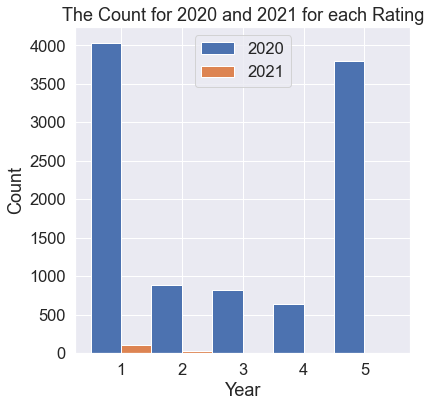

In [28]:
sns.set(font_scale=1.5)
Year_2020  = df[df['Review_year']==2020] ['Rating'].value_counts() 
Year_2021  = df[df['Review_year']==2021] ['Rating'].value_counts() 

plt.figure(figsize=(6,6))
plt.bar(Year_2020.index, Year_2020.values, width=-0.5,bottom=None, align='edge', label='2020')
plt.bar(Year_2021.index, Year_2021.values, width=0.5,bottom=None, align='edge', label='2021')

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("The Count for 2020 and 2021 for each Rating")
plt.legend()
plt.show()

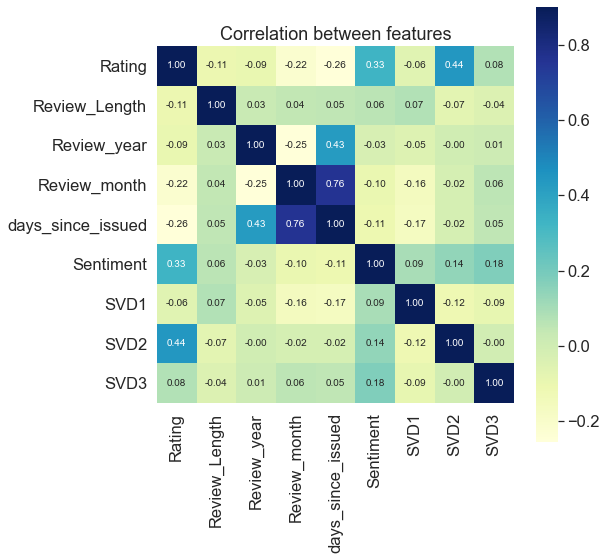

In [29]:
sns.set(font_scale=1.5)
Correlation = df.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(Correlation, vmax=0.9, annot_kws={'size': 10},square=True, annot=True, fmt=".2f",cmap="YlGnBu")
plt.title('Correlation between features')
plt.show()

# Model comparison and model building

In [30]:
#Drop 'Review_cleaned' and 'days_since_issued'
df.drop(columns='Review_cleaned',inplace=True)
df.drop(columns='days_since_issued',inplace=True)

#Transform Nominal to Numerical
df['Version']=df['Version'].astype('category').cat.codes
df_dummy=pd.get_dummies((df), prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

#Reference: Pandas.pydata.org. 2021. pandas.get_dummies — pandas 1.2.4 documentation. [online] Available at: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html> [Accessed 2 June 2021].


In [31]:
df_dummy

,Rating,Version,Review_Length,Review_year,Review_month,Sentiment,SVD1,SVD2,SVD3,AppStore_Apple,AppStore_Google
0,1,0,36,2020,4,0.4019,0.048570,0.007709,-0.001385,1,0
1,1,0,35,2020,4,0.0000,0.048813,-0.015531,-0.002857,1,0
2,1,0,23,2020,4,0.3612,0.056905,-0.016172,-0.001952,1,0
3,1,0,14,2020,4,-0.2960,0.040576,-0.016172,-0.001644,1,0
4,2,0,67,2020,4,-0.4019,0.077479,-0.013544,-0.003745,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10332,2,14,21,2021,1,0.4404,0.160439,-0.043551,0.012646,0,1
10333,1,14,12,2021,1,0.0000,0.083178,0.039534,-0.019111,0,1
10334,1,14,27,2021,1,0.0000,0.074372,-0.005064,-0.001631,0,1
10335,1,14,17,2021,1,0.3612,0.055002,-0.001492,0.002160,0,1


In [32]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn import datasets

plt.style.use('ggplot')

In [33]:
y = df_dummy['Rating']
X = df_dummy.drop(['Rating'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)
kfold = model_selection.KFold(n_splits=10, shuffle=True)

In [34]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [35]:
#Model compare and result
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.544079 (0.010841)
DTC: 0.499940 (0.012608)
NB: 0.501027 (0.016425)


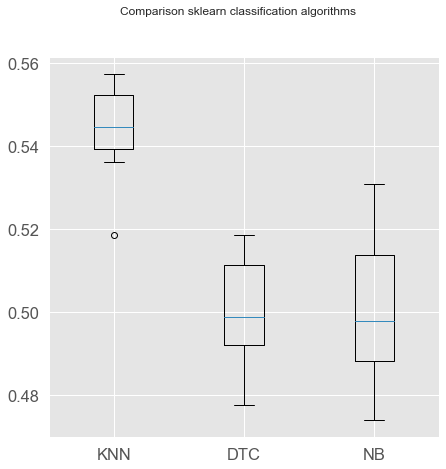

In [36]:
fig = plt.figure(figsize=(7,7))
fig.suptitle('Comparison sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
#Comparison sklearn classification algorithms

In [37]:
#Normalize
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [39]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

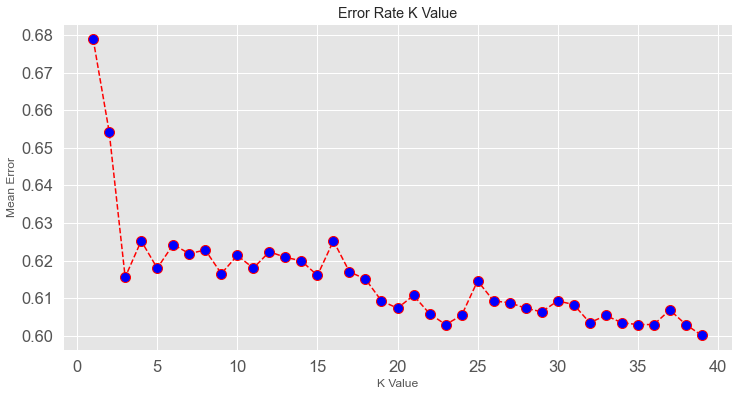

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [41]:
from sklearn.metrics import classification_report
knn=KNeighborsClassifier(n_neighbors=22)
knn.fit(x_train,y_train)
result=knn.predict(x_test)
target_names = ["Rating_1","Rating_2","Rating_3","Rating_4","Rating_5"]
print(classification_report(y_test,result,labels=[1,2,3,4,5], target_names=target_names))

              precision    recall  f1-score   support

    Rating_1       0.63      0.86      0.73       862
    Rating_2       0.33      0.01      0.02       173
    Rating_3       0.10      0.01      0.01       141
    Rating_4       0.00      0.00      0.00       140
    Rating_5       0.68      0.80      0.73       752

    accuracy                           0.65      2068
   macro avg       0.35      0.33      0.30      2068
weighted avg       0.55      0.65      0.57      2068

